# CRPS plots
28th December 2024

In [167]:
import glob
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.io import shapereader
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from shapely.geometry import LinearRing
import matplotlib.patheffects as pe

import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')  # noqa
from load import data_dir

In [185]:
# Load CRPS data
crps_rcm_df = pd.read_csv('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/moe_outputs/rcm_crps_alpha_historical_1981_2005_ref_1951_1980.csv', index_col=0)
crps_rcm_ds = xr.Dataset.from_dataframe(crps_rcm_df.set_index(['month', 'lon', 'lat']))

## MOE - EW CRPS

In [201]:
crps_rcm_ds['crps_diff'] = (crps_rcm_ds['ew']/crps_rcm_ds['moe'] - 1)* 100

In [189]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [190]:
def regional_rectangle(lonmin, lonmax, latmin, latmax, nvert=100):
    """ Return Polygon object to create regional rectangle on maps."""
    lons = np.r_[
        np.linspace(lonmin, lonmin, nvert),
        np.linspace(lonmin, lonmax, nvert),
        np.linspace(lonmax, lonmax, nvert),
    ].tolist()

    lats = np.r_[
        np.linspace(latmin, latmax, nvert),
        np.linspace(latmax, latmax, nvert),
        np.linspace(latmax, latmin, nvert),
    ].tolist()

    pgon = LinearRing(list(zip(lons, lats)))

    return pgon

In [191]:
hma1 = regional_rectangle(71, 79, 32, 39)
hma2 = regional_rectangle(76, 93, 27, 32)
hma3 = regional_rectangle(93, 103, 28, 36)
region_dict2 = {'HMA1': [71.5, 37.5], 'HMA2': [76.5, 30.5], 'HMA3': [93.5, 34.5],}
proj = ccrs.PlateCarree()

In [192]:
# HKH region
hkh_region_path = data_dir + "Shapefiles/hkh/outline.shp"
hkh_region_shape = shapereader.Reader(hkh_region_path)
hkh_region_globe = ccrs.Globe(semimajor_axis=6377276.345, inverse_flattening=300.8017)
hkh_region = ccrs.PlateCarree()

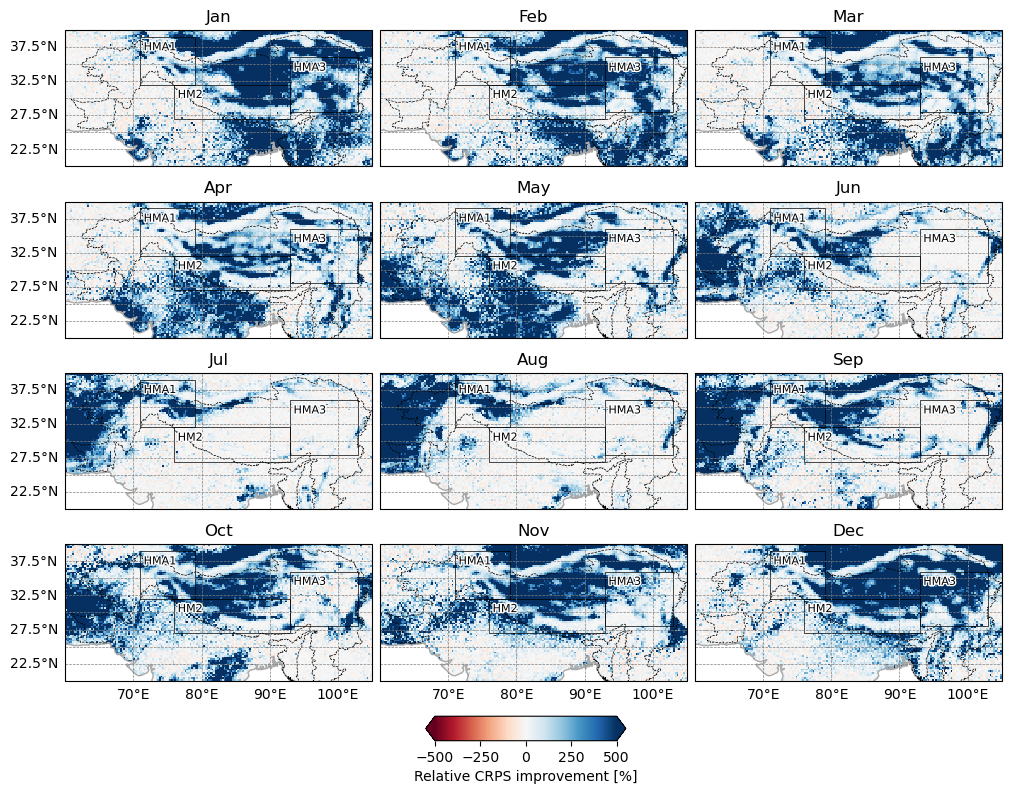

In [208]:
fig, ax = plt.subplots(4, 3, figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

ocean_50m = cf.NaturalEarthFeature(
        "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(12):
    g = crps_rcm_ds.crps_diff.sel(month=i+1).plot(x='lon', y='lat', ax=ax[i//3, i%3], cmap='RdBu', center=0, vmax=500, add_colorbar=False, linewidth=0, rasterized=True)
    ax[i//3, i%3].set_title(months[i])
    gl = ax[i//3, i%3].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    if i % 3 != 0:
       gl.left_labels = False
    if i // 3 != 3:
        gl.bottom_labels = False
    ax[i//3, i%3].add_feature(ocean_50m)
    ax[i//3, i%3].add_geometries([hma1, hma2, hma3], proj, edgecolor="black",
            facecolor="None", linestyle='-', linewidth=0.5)
    for region, coord in region_dict2.items():
        ax[i//3, i%3].text(coord[0], coord[1], region, fontsize=8, color='black', ha='left', va='center', zorder=10, 
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    for rec in hkh_region_shape.records():
        ax[i//3, i%3].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="black",
            facecolor="None",
            linestyle='--',
            linewidth=0.5) 

cax = fig.add_axes([0.42, -0.05, 0.2, 0.035])
fig.colorbar(g, cax=cax, orientation='horizontal', label='Relative CRPS improvement [%]', extend='both')

plt.savefig('moe_ew_relative_crps_alpha_nop95_1981_2005.pdf', bbox_inches='tight')

## Calculate scores over the subregions

In [160]:
hma1_crps_diff = crps_rcm_ds.sel(lon=slice(71, 79), lat=slice(32, 39)).mean(dim=['lon', 'lat'])
print(hma1_crps_diff.crps_diff.mean(dim='month'))

<xarray.DataArray 'crps_diff' ()>
array(-0.34316379)


In [161]:
hma2_crps_diff = crps_rcm_ds.sel(lon=slice(76, 93), lat=slice(27, 32)).mean(dim=['lon', 'lat'])
print(hma2_crps_diff.crps_diff.mean(dim='month'))

<xarray.DataArray 'crps_diff' ()>
array(-0.24468152)


In [162]:
hma3_crps_diff = crps_rcm_ds.sel(lon=slice(93, 103), lat=slice(28, 36)).mean(dim=['lon', 'lat'])
print(hma3_crps_diff.crps_diff.mean(dim='month'))

<xarray.DataArray 'crps_diff' ()>
array(-0.14696205)


### RCM averages

In [186]:
crps_rcm_ds[list(crps_rcm_ds)[:13]]-=crps_rcm_ds['moe']
crps_rcm_ds[list(crps_rcm_ds)[:13]]*=-1
crps_rcm_mean_ds = crps_rcm_ds.mean(dim='month')

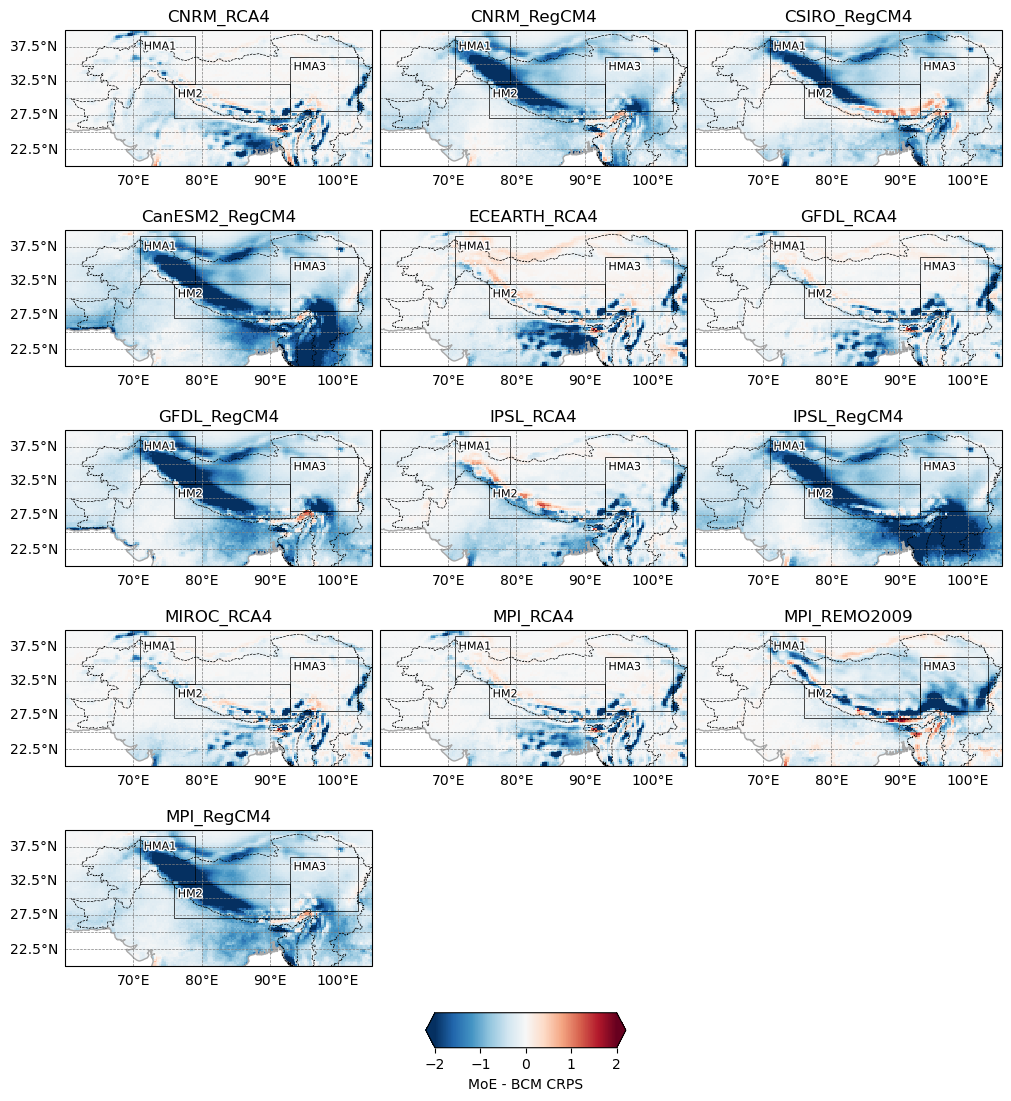

In [194]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

ocean_50m = cf.NaturalEarthFeature(
        "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(13):
    name = list(crps_rcm_ds)[i]
    g = crps_rcm_mean_ds[name].plot(x='lon', y='lat', ax=ax[i//3, i%3], cmap='RdBu_r', center=0, vmax=2, add_colorbar=False, linewidth=0, rasterized=True)
    ax[i//3, i%3].set_title(name)
    gl = ax[i//3, i%3].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels = False
    if i % 3 != 0:
       gl.left_labels = False
    #if i // 3 != 3:
    #    gl.bottom_labels = False
    #if i // 3 == 3:
    #    if i % 3 == 0:
    #        gl.bottom_labels = False
    #if i // 3 == 4:
    #    if i % 3 == 0:
    #        gl.bottom_labels = True
    
    ax[i//3, i%3].add_feature(ocean_50m)
    ax[i//3, i%3].add_geometries([hma1, hma2, hma3], proj, edgecolor="black",
            facecolor="None", linestyle='-', linewidth=0.5)
    for region, coord in region_dict2.items():
        ax[i//3, i%3].text(coord[0], coord[1], region, fontsize=8, color='black', ha='left', va='center', zorder=10, 
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    for rec in hkh_region_shape.records():
        ax[i//3, i%3].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="black",
            facecolor="None",
            linestyle='--',
            linewidth=0.5) 

cax = fig.add_axes([0.42, -0.05, 0.2, 0.035])
fig.colorbar(g, cax=cax, orientation='horizontal', label='MoE - BCM CRPS', extend='both')

fig.delaxes(ax[4, 2])
fig.delaxes(ax[4, 1])

plt.savefig('moe_rcm_crps_alpha_nop95_1981_2005.pdf', bbox_inches='tight')